In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
# Import CMasher to register colormaps
import cmasher as cmr
from datetime import datetime
import seaborn as sns
import cftime
import glob


In [4]:
#Coordenadas de estaciones 
cor=pd.read_csv("clustering_Had.csv")

#Seleciconando las latitudes y las longitudes
lat=cor.lat
lon=cor.Lon

In [5]:
#Encontrando las estaciones dentro de MSD
#11,18,-96,-88
sid_MSD=cor.loc[(cor.lat>=11)&(cor.lat<=18.5)&(cor.Lon>=-97)&(cor.Lon<=-88)]

sid_MSD=sid_MSD.loc[(sid_MSD.index!=82)&(sid_MSD.index!=87)] #Quitando las estaciones con enfriamiento

#Cargando los datos de ERA5-Land
# Usar glob para seleccionar todos los archivos CSV en la ruta
archivos_nc = sorted(glob.glob("/home/andreagvc/data/ERA/ERA/ERA_*_hourly_rec*.nc"))

#Combinando los datos 
ds_combinado=xr.open_mfdataset(archivos_nc,combine="by_coords")


In [6]:
#Seleccionando las variables con las estaciones dentro del área de MSD

Tw_ERA_d=ds_combinado.TWB_d.loc[ds_combinado.TWB_d.sid.isin(sid_MSD)]
T_ERA_d=ds_combinado.T_d.loc[ds_combinado.T_d.sid.isin(sid_MSD)]
q_ERA_d=ds_combinado.q_d.loc[ds_combinado.q_d.sid.isin(sid_MSD)]

In [7]:
#Cargando las fechas
MSD=pd.read_csv("average_dates_1979-2018.csv")

#PASANDO LAS FECHAS A FORMATO DATETIME
MSD["Onset"]=pd.to_datetime(MSD["Onset"])
MSD["Year"]=pd.to_datetime(MSD["Year"])
MSD["Retreat"]=pd.to_datetime(MSD["Retreat"])
MSD["MSDO"]=pd.to_datetime(MSD["MSDO"])
MSD["MSDE"]=pd.to_datetime(MSD["MSDE"])


In [8]:
#Promediando las estaciones que tienen canícula
Tw_ERA=Tw_ERA_d.mean("sid")

T_ERA=T_ERA_d.mean("sid")

q_ERA=q_ERA_d.mean("sid")


In [11]:
# Recorte Early Dry Season
def DS_rec(datos):
    for i,ii in enumerate(MSD.Onset.dt.date):
        data=datos.loc[(datos.time.dt.year==MSD.Onset.dt.year[i])&(datos.time.dt.month>2)&(datos.time.dt.date<=ii)]
        if i==0:
            dry_spring=data

        else:
            new = xr.concat([dry_spring, data], dim="time")
            dry_spring=new
    return dry_spring

In [12]:
Tw_dry_spring=DS_rec(Tw_ERA)
T_dry_spring=DS_rec(T_ERA)
q_dry_spring=DS_rec(q_ERA)

In [13]:
#Recorte Midsummer Drought
def MSD_period(datos):
    for i,ii in enumerate(MSD.MSDO.dt.date):
        data=datos.loc[(datos.time.dt.year==MSD.MSDO.dt.year[i])&(datos.time.dt.date>=ii) & (datos.time.dt.date<=MSD.MSDE.dt.date.iloc[i])]
        if i==0:
            g=data

        else:

            new = xr.concat([g, data], dim="time")
            g=new
    return g

In [14]:
Tw_MSD=MSD_period(Tw_ERA)
T_MSD=MSD_period(T_ERA)
q_MSD=MSD_period(q_ERA)

In [15]:
#Recorte Deep Wet Season
def MSD_winterdry (datos):
    for i,ii in enumerate(MSD.Retreat.dt.date):
        data=datos.loc[(datos.time.dt.year==MSD.Retreat.dt.year[i]) &(datos.time.dt.date>=ii)]
        if i==0:
            g=data

        else:

            new = xr.concat([g, data], dim="time")
            g=new
    return g

In [16]:
Tw_MSD_wdry=MSD_winterdry(Tw_ERA)
T_MSD_wdry=MSD_winterdry(T_ERA)
q_MSD_wdry=MSD_winterdry(q_ERA)

In [17]:
#Recorte Fist Peak
def onset_MSDO (datos):
    for i,ii in enumerate(MSD.Onset.dt.date):
        data=datos.loc[(datos.time.dt.year==MSD.Onset.dt.year[i]) &(datos.time.dt.date>=ii) & (datos.time.dt.date<=MSD.MSDO.dt.date.iloc[i])]
        if i==0:
            g=data

        else:

            new = xr.concat([g, data], dim="time")
            g=new
    return g

In [18]:
Tw_fpeak_ERA=onset_MSDO(Tw_ERA)
T_fpeak_ERA=onset_MSDO(T_ERA)
q_fpeak_ERA=onset_MSDO(q_ERA)

In [19]:
#Recorte Second Peak
def MSDE_retreat (datos):
    for i,ii in enumerate(MSD.MSDE.dt.date):
        data=datos.loc[(datos.time.dt.year==MSD.MSDE.dt.year[i]) &(datos.time.dt.date>=ii) & (datos.time.dt.date<=MSD.Retreat.dt.date.iloc[i])]
        if i==0:
            g=data

        else:

            new = xr.concat([g, data], dim="time")
            g=new
    return g

In [20]:
Tw_speak_ERA=MSDE_retreat(Tw_ERA)
T_speak_ERA=MSDE_retreat(T_ERA)
q_speak_ERA=MSDE_retreat(q_ERA)

In [21]:
#Recortando los datos de HadISD

df=pd.read_csv("/home/andreagvc/data/ERA/ERA/IDD.csv",header=None)
ID=df[(df[0]>="760011-99999")&(df[0]<="780160-13601")] 
ID1=ID[0].str.split(pat="-", expand=True) #Separando 
ID["ID"]=ID1[0].astype(int)

esta=pd.read_fwf("/home/andreagvc/data/ERA/ERA/ID.txt",header=None)
p=esta[1]
filtered_df = ID[(ID["ID"]).isin(p)]
filtered_df #Encontrando los datos de las estaciones que ocupamos
lat=filtered_df[2].values
lon=filtered_df[3].values
ele=filtered_df[4].values

#Agregando la elevación al dataframe
esta["elevacion"]=ele
esta["Lat"]=lat
esta["Lon"]=lon
esta["Lugar"]=filtered_df[1].values

/tmp/ipykernel_182003/400069161.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ID["ID"]=ID1[0].astype(int)


In [22]:
#Cargando los datos de las estaciones Had_ISD pero horarios
da_list=[]
for i,ii in enumerate(sid_MSD.ID):
    datos=xr.open_dataset(f"/home/andreagvc/data/ERA/ERA/Datos_HAD/{ii}99999.nc")
    datos=datos.assign_coords(estacion=ii)
    datos=datos.expand_dims('estacion')
    da_list.append(datos)

In [23]:
HAD=xr.concat(da_list,dim='estacion')

In [24]:
Tw_Had=HAD.Tw.where(HAD.Tw.time.dt.year>1978,drop=True)
T_Had=HAD.T.where(HAD.T.time.dt.year>1978,drop=True)
q_Had=HAD.SH.where(HAD.SH.time.dt.year>1978,drop=True)

In [25]:
#Promediando las estaciones que tienen canícula en HadISD
Tw_Had=Tw_Had.mean("estacion")

T_Had=T_Had.mean("estacion")

q_Had=q_Had.mean("estacion")


In [26]:
#Recorte periodo Early Dry Season
Tw_drys_HAD=DS_rec(Tw_Had)
T_drys_HAD=DS_rec(T_Had)
q_drys_HAD=DS_rec(q_Had)

In [27]:
#Recorte periodo Midsummer Drought
Tw_MSD_HAD=MSD_period(Tw_Had)
T_MSD_HAD=MSD_period(T_Had)
q_MSD_HAD=MSD_period(q_Had)

In [28]:
#Recorte periodo Deep Wet Season
Tw_wdry_HAD=MSD_winterdry(Tw_Had)
T_wdry_HAD=MSD_winterdry(T_Had)
q_wdry_HAD=MSD_winterdry(q_Had)

In [29]:
#Recorte First Peak
Tw_fpeak_HAD=onset_MSDO(Tw_Had)
T_fpeak_HAD=onset_MSDO(T_Had)
q_fpeak_HAD=onset_MSDO(q_Had)

In [30]:
#Recorte Second Peak
Tw_speak_HAD=MSDE_retreat(Tw_Had)
T_speak_HAD=MSDE_retreat(T_Had)
q_speak_HAD=MSDE_retreat(q_Had)

In [32]:
data = [Tw_drys_HAD-273.15,Tw_fpeak_HAD-273.15,Tw_MSD_HAD-273.15,Tw_speak_HAD-273.15, Tw_wdry_HAD-273.15, 
        T_drys_HAD,T_fpeak_HAD,T_MSD_HAD,T_speak_HAD,
        T_wdry_HAD, q_drys_HAD*1000,q_fpeak_HAD*1000,q_MSD_HAD*1000,q_speak_HAD*1000, q_wdry_HAD*1000, Tw_dry_spring,Tw_fpeak_ERA,Tw_MSD,Tw_speak_ERA, 
        Tw_MSD_wdry, T_dry_spring,T_fpeak_ERA,T_MSD,T_speak_ERA, T_MSD_wdry,q_dry_spring*1000,q_fpeak_ERA*1000,q_MSD*1000,q_speak_ERA*1000, 
        q_MSD_wdry*1000]
d=[]
# Supongamos que tenemos los siguientes datos para agregar
dataset = ["HadISD","ERA5-Land"]
periodo = ["DS", "FP","MSD","SP","DW"]
var=["TW","T","SH"]
n=0
p=0
# Usamos un ciclo for para llenar el DataFrame
for i in range(len(data)):
    #print(i)
    if i<15:
        datos=dataset[0]
    else:
        datos=dataset[1]
    
    
    # Añadir una fila al DataFrame en cada iteración
    prom=np.array(data[i].mean())
    perc = np.percentile(data[i], 95)
   
    #print(perc)
    d.append([datos, periodo[n], var[p],prom, perc])
    n=n+1
    if n==5:
        n=0
        p=p+1
    if p==3:
        p=0
    

# Crear un DataFrame a partir de la lista de listas
df = pd.DataFrame(d, columns=["Dataset", "Periodo", "Variable","Promedio","P95"])

# Mostrar el DataFrame
print(df)

      Dataset Periodo Variable            Promedio        P95
0      HadISD      DS       TW   20.84657864938766  25.030000
1      HadISD      FP       TW  22.317510263596017  25.795167
2      HadISD     MSD       TW  22.191646293875994  25.510000
3      HadISD      SP       TW  21.908448564570904  25.136958
4      HadISD      DW       TW   19.71387426283537  23.830000
5      HadISD      DS        T  25.112092553924246  32.100000
6      HadISD      FP        T   25.75335008740303  32.000000
7      HadISD     MSD        T   25.17258165637973  30.642857
8      HadISD      SP        T   24.46809094056283  30.000000
9      HadISD      DW        T  22.496200096357807  28.700000
10     HadISD      DS       SH  14.706632536013336  18.518963
11     HadISD      FP       SH  16.509072885182697  19.537343
12     HadISD     MSD       SH  16.557409497949415  19.176388
13     HadISD      SP       SH  16.428469606777462  18.990996
14     HadISD      DW       SH  14.214986843985614  17.528822
15  ERA5

In [33]:
#Guardando el dataframe como csv
df.to_csv("esta_MSD.csv",index=False)

In [34]:
#Cargando el archivo antes guardado
estadis=pd.read_csv("esta_MSD.csv")

In [35]:
#Separando los datos de ERA5-Land y HadISD
ERA=estadis.loc[estadis.Dataset=="ERA5-Land"]
HAD_e=estadis.loc[estadis.Dataset=="HadISD"]

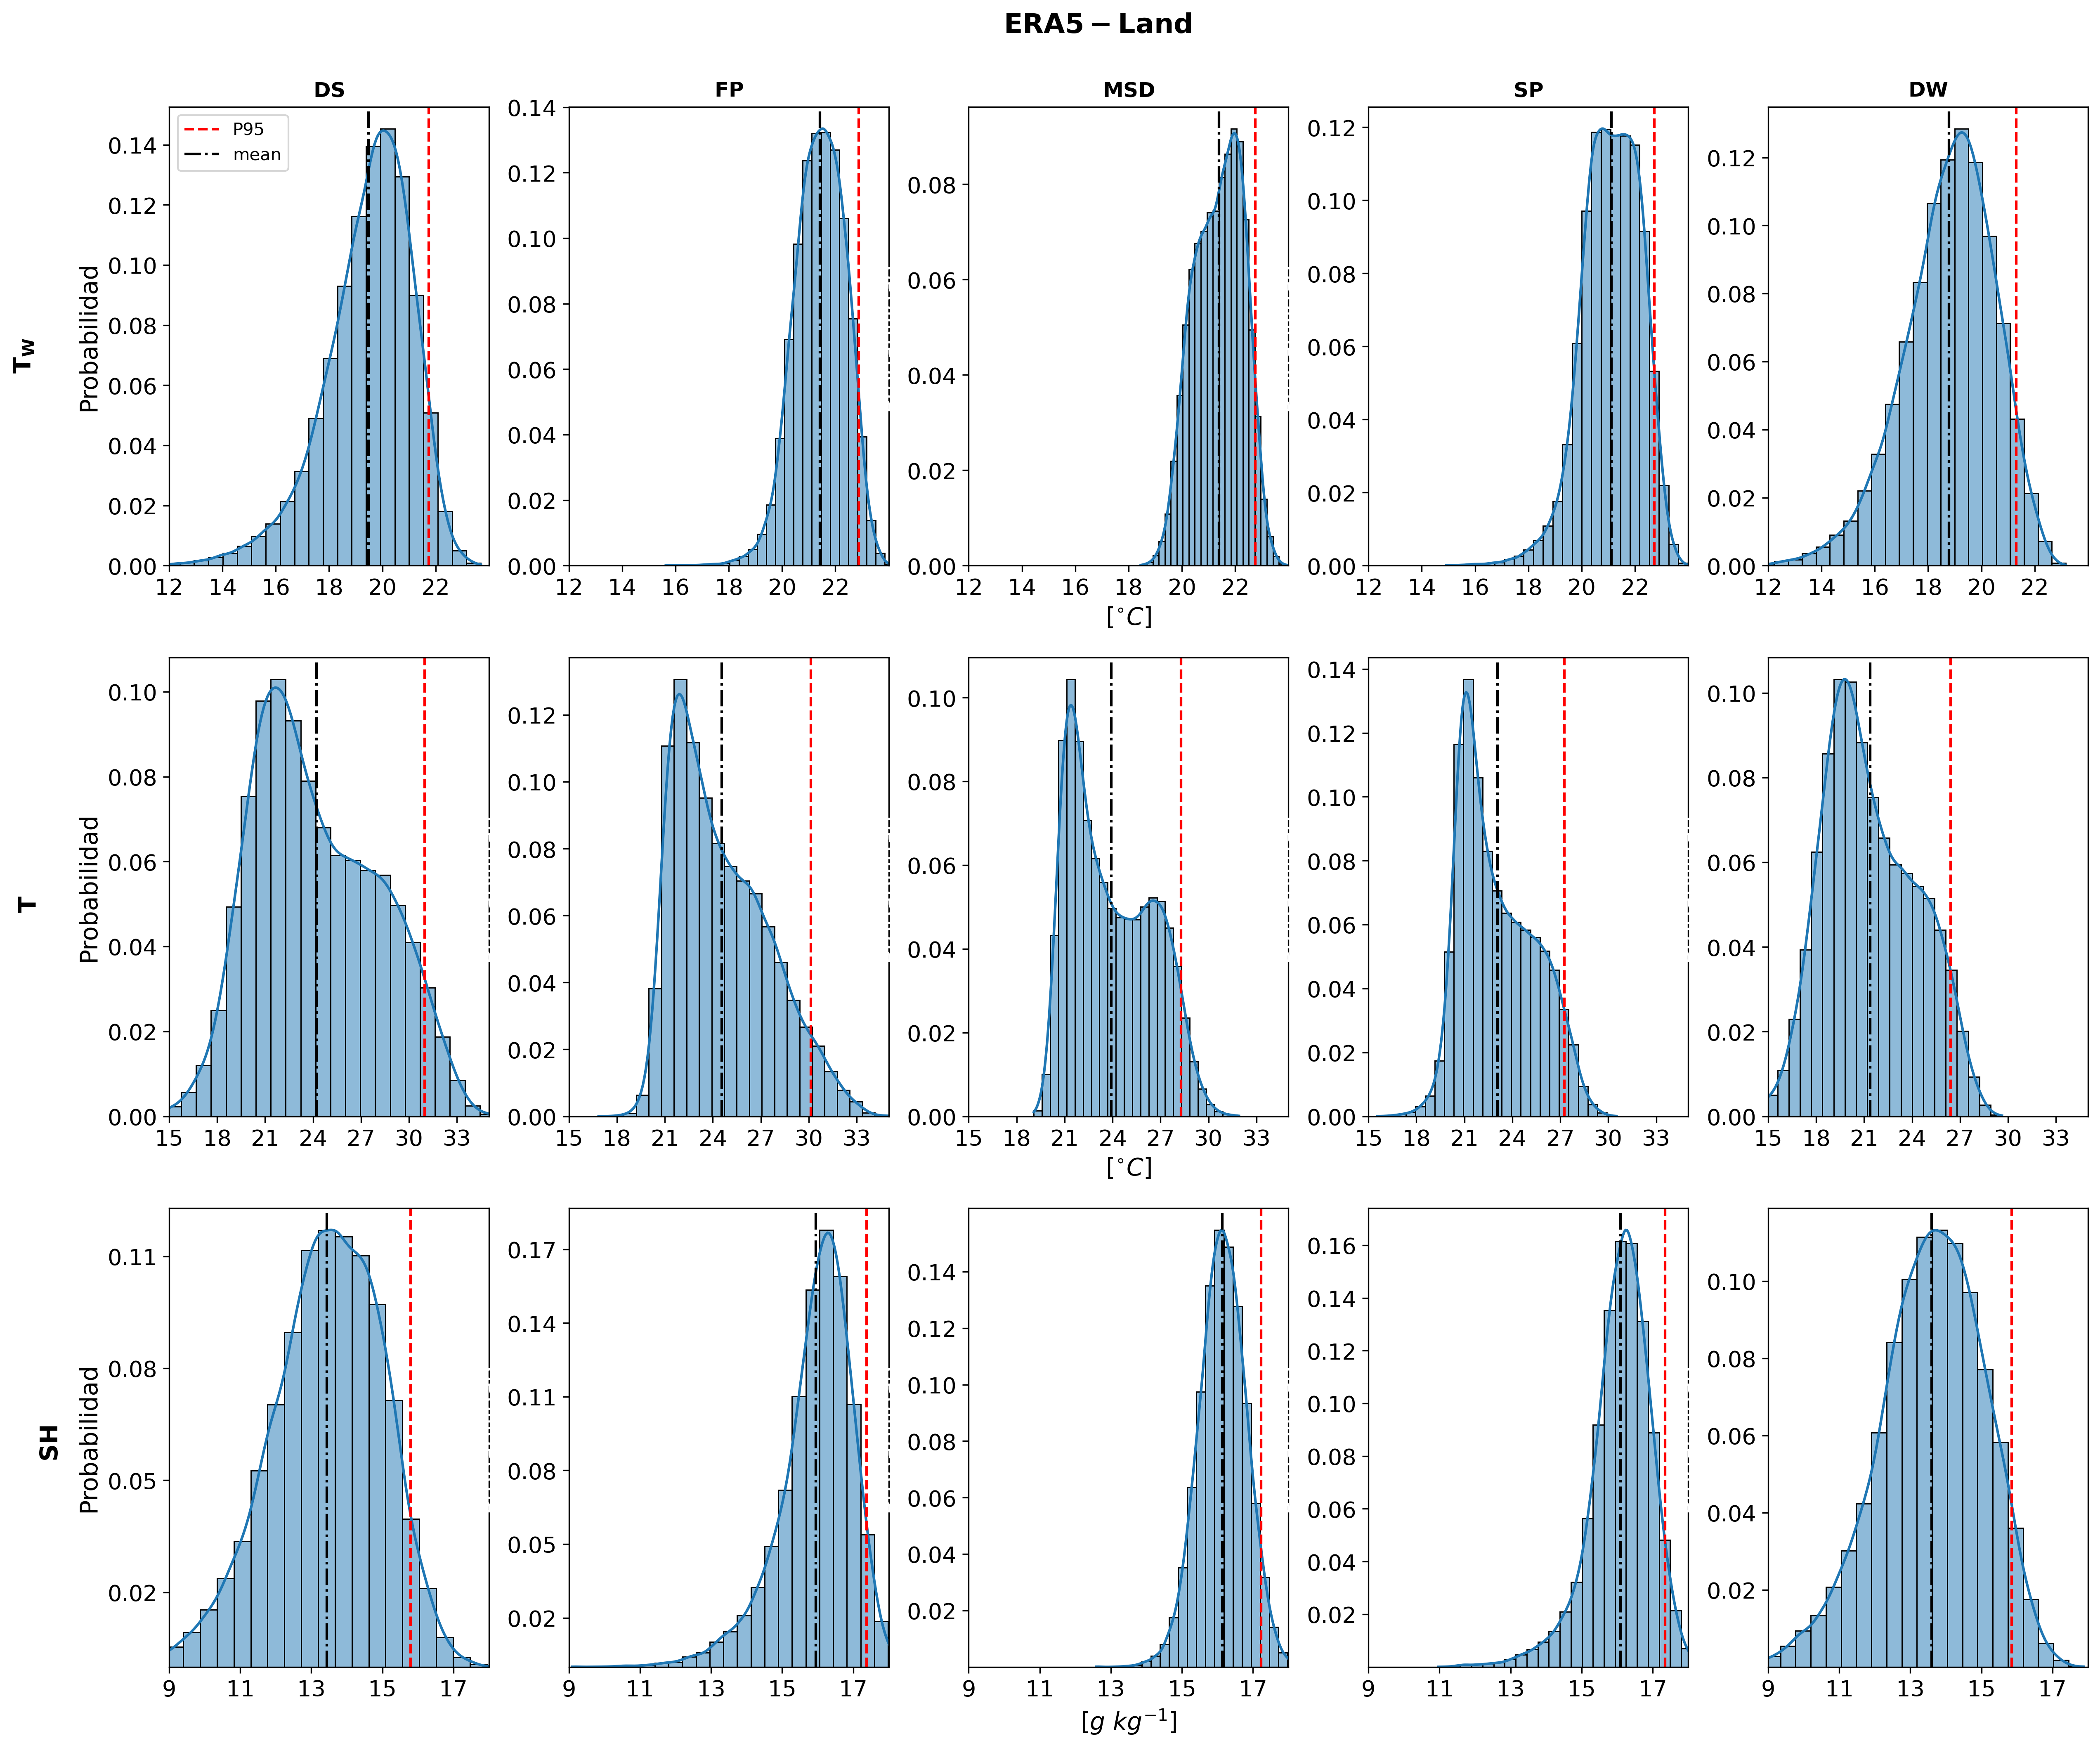

In [37]:
#Distribución de probabilidad

plt.figure(figsize=(20, 15),dpi=300)

plt.subplot(3,5,2)

sns.histplot(data=Tw_fpeak_ERA,  kde=True,stat="probability" ,kde_kws={'bw_adjust':1.25},bins=25)  # Cambiar el estilo del gráfico

plt.yticks(fontsize=13)
plt.title(r"$\mathbf{FP}$",fontsize=12)
plt.axvline(ERA.P95.iloc[1], color='red', linestyle='--',label="P95")
plt.axvline(ERA.Promedio.iloc[1], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(12,24,2),fontsize=13)
plt.xlim(12,24)

plt.ylabel("Probabilidad",fontsize=14,color="white")

plt.subplot(3,5,5)
sns.histplot(data=Tw_MSD_wdry, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(ERA.P95.iloc[4], color='red', linestyle='--')
plt.axvline(ERA.Promedio.iloc[4], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(12,24,2),fontsize=13)
plt.xlim(12,24)
plt.yticks(fontsize=13)
plt.title(r"$\mathbf{DW}$",fontsize=12)


plt.ylabel("Probabilidad",fontsize=14,color="white")

plt.subplot(3,5,3)
sns.histplot(data=Tw_MSD, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(ERA.P95.iloc[2], color='red', linestyle='--')
plt.axvline(ERA.Promedio.iloc[2], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(12,24,2),fontsize=13)
plt.xlim(12,24)
plt.yticks(fontsize=13)
plt.title(r"$\mathbf{MSD}$",fontsize=12)
plt.xlabel("$[^{\circ}C]$",fontsize=14)
plt.ylabel("Probabilidad",fontsize=14,color="white")

plt.subplot(3,5,4)
sns.histplot(data=Tw_speak_ERA, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(ERA.P95.iloc[3], color='red', linestyle='--')
plt.axvline(ERA.Promedio.iloc[3], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(12,24,2),fontsize=13)
plt.xlim(12,24)
plt.yticks(fontsize=13)
plt.title(r"$\mathbf{SP}$",fontsize=12)


plt.ylabel("Probabilidad",fontsize=14,color="white")

plt.subplot(3,5,1)
ax=sns.histplot(data=Tw_dry_spring, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(ERA.P95.iloc[0], color='red', linestyle='--',label="P95")
plt.axvline(ERA.Promedio.iloc[0], color='black', linestyle='-.',label="mean")
plt.title(r"$\mathbf{DS}$",fontsize=12)
ax.text(7, 0.07, r'$\mathbf{T}$$\mathbf{_W}$',fontsize=14, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor')
plt.xticks(np.arange(12,24,2),fontsize=13)
plt.xlim(12,24)
plt.yticks(fontsize=13)
plt.legend(loc="upper left")


plt.ylabel("Probabilidad",fontsize=14)

plt.subplot(3,5,6)
ax=sns.histplot(data=T_dry_spring,  kde=True,stat="probability" ,kde_kws={'bw_adjust':1.25},bins=25)
plt.axvline(ERA.P95.iloc[5], color='red', linestyle='--')
plt.axvline(ERA.Promedio.iloc[5], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(15,35,3),fontsize=13)
plt.xlim(15,35)
plt.yticks(fontsize=13)
ax.text(7, 0.05, r'$\mathbf{T}$',fontsize=14, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor')



plt.ylabel("Probabilidad",fontsize=14)

plt.subplot(3,5,7)
sns.histplot(data=T_fpeak_ERA, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(ERA.P95.iloc[6], color='red', linestyle='--')
plt.axvline(ERA.Promedio.iloc[6], color='black', linestyle='-.',label="mean")

plt.xticks(np.arange(15,35,3),fontsize=13)
plt.xlim(15,35)
plt.yticks(fontsize=13)



plt.ylabel("Probabilidad",fontsize=14,color="white")


plt.subplot(3,5,8)
sns.histplot(data=T_MSD, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(ERA.P95.iloc[7], color='red', linestyle='--')
plt.axvline(ERA.Promedio.iloc[7], color='black', linestyle='-.',label="mean")

plt.xticks(np.arange(15,35,3),fontsize=13)
plt.xlim(15,35)
plt.yticks(fontsize=13)

plt.xlabel("$[^{\circ}C]$",fontsize=14)
plt.ylabel("Probabilidad",fontsize=14,color="white")

plt.subplot(3,5,9)
sns.histplot(data=T_speak_ERA, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(ERA.P95.iloc[8], color='red', linestyle='--')
plt.axvline(ERA.Promedio.iloc[8], color='black', linestyle='-.',label="mean")

plt.xticks(np.arange(15,35,3),fontsize=13)
plt.xlim(15,35)
plt.yticks(fontsize=13)

plt.ylabel("Probabilidad",fontsize=14,color="white")


plt.subplot(3,5,10)
sns.histplot(data=T_MSD_wdry, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(ERA.P95.iloc[9], color='red', linestyle='--')
plt.axvline(ERA.Promedio.iloc[9], color='black', linestyle='-.',label="mean")

plt.xticks(np.arange(15,35,3),fontsize=13)
plt.xlim(15,35)
plt.yticks(fontsize=13)


plt.ylabel("Probabilidad",fontsize=14,color="white")


plt.subplot(3,5,11)
ax=sns.histplot(data=q_dry_spring*1000,  kde=True,stat="probability" ,kde_kws={'bw_adjust':1.25},bins=25)
plt.axvline(ERA.P95.iloc[10], color='red', linestyle='--')
plt.axvline(ERA.Promedio.iloc[10], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(9,18,2),fontsize=13)
plt.xlim(9,18)
plt.yticks(np.arange(0.02, 0.12,0.03),fontsize=13)
ax.text(6, 0.06, r'$\mathbf{SH}$',fontsize=14, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor')


plt.ylabel("Probabilidad",fontsize=14)

plt.subplot(3,5,12)
sns.histplot(data=q_fpeak_ERA*1000, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(ERA.P95.iloc[11], color='red', linestyle='--')
plt.axvline(ERA.Promedio.iloc[11], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(9,18,2),fontsize=13)
plt.xlim(9,18)
plt.yticks(np.arange(0.02, 0.18,0.03),fontsize=13)



plt.ylabel("Probabilidad",fontsize=14,color="white")


plt.subplot(3,5,13)
sns.histplot(data=q_MSD*1000, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(ERA.P95.iloc[12], color='red', linestyle='--')
plt.axvline(ERA.Promedio.iloc[12], color='black', linestyle='-.',label="mean")

plt.xticks(np.arange(9,18,2),fontsize=13)
plt.xlim(9,18)
plt.yticks(np.arange(0.02, 0.15,0.02),fontsize=13)
plt.ylabel("Probabilidad",fontsize=14,color="white")


plt.xlabel("[$g$ $kg^{-1}$]",fontsize=14)
plt.ylabel("Probabilidad",fontsize=14,color="white")

plt.subplot(3,5,14)
sns.histplot(data=q_speak_ERA*1000, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(ERA.P95.iloc[13], color='red', linestyle='--')
plt.axvline(ERA.Promedio.iloc[13], color='black', linestyle='-.',label="mean")

plt.xticks(np.arange(9,18,2),fontsize=13)
plt.xlim(9,18)
plt.yticks(np.arange(0.02, 0.17,0.02),fontsize=13)



plt.ylabel("Probabilidad",fontsize=14,color="white")

plt.subplot(3,5,15)
sns.histplot(data=q_MSD_wdry*1000, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(ERA.P95.iloc[14], color='red', linestyle='--')
plt.axvline(ERA.Promedio.iloc[14], color='black', linestyle='-.',label="mean")

plt.xticks(np.arange(9,18,2),fontsize=13)
plt.xlim(9,18)
plt.yticks(np.arange(0.02, 0.12,0.02),fontsize=13)


plt.ylabel("Probabilidad",fontsize=14,color="white")
plt.suptitle(r"$\mathbf{ERA5-Land}$", fontsize=16,y=1.001)
plt.subplots_adjust(top=0.95,wspace=0.25)
plt.savefig("MSD_ERA.svg",bbox_inches="tight",dpi=300)
plt.savefig("MSD_ERA.png",bbox_inches="tight",dpi=300)

plt.show()

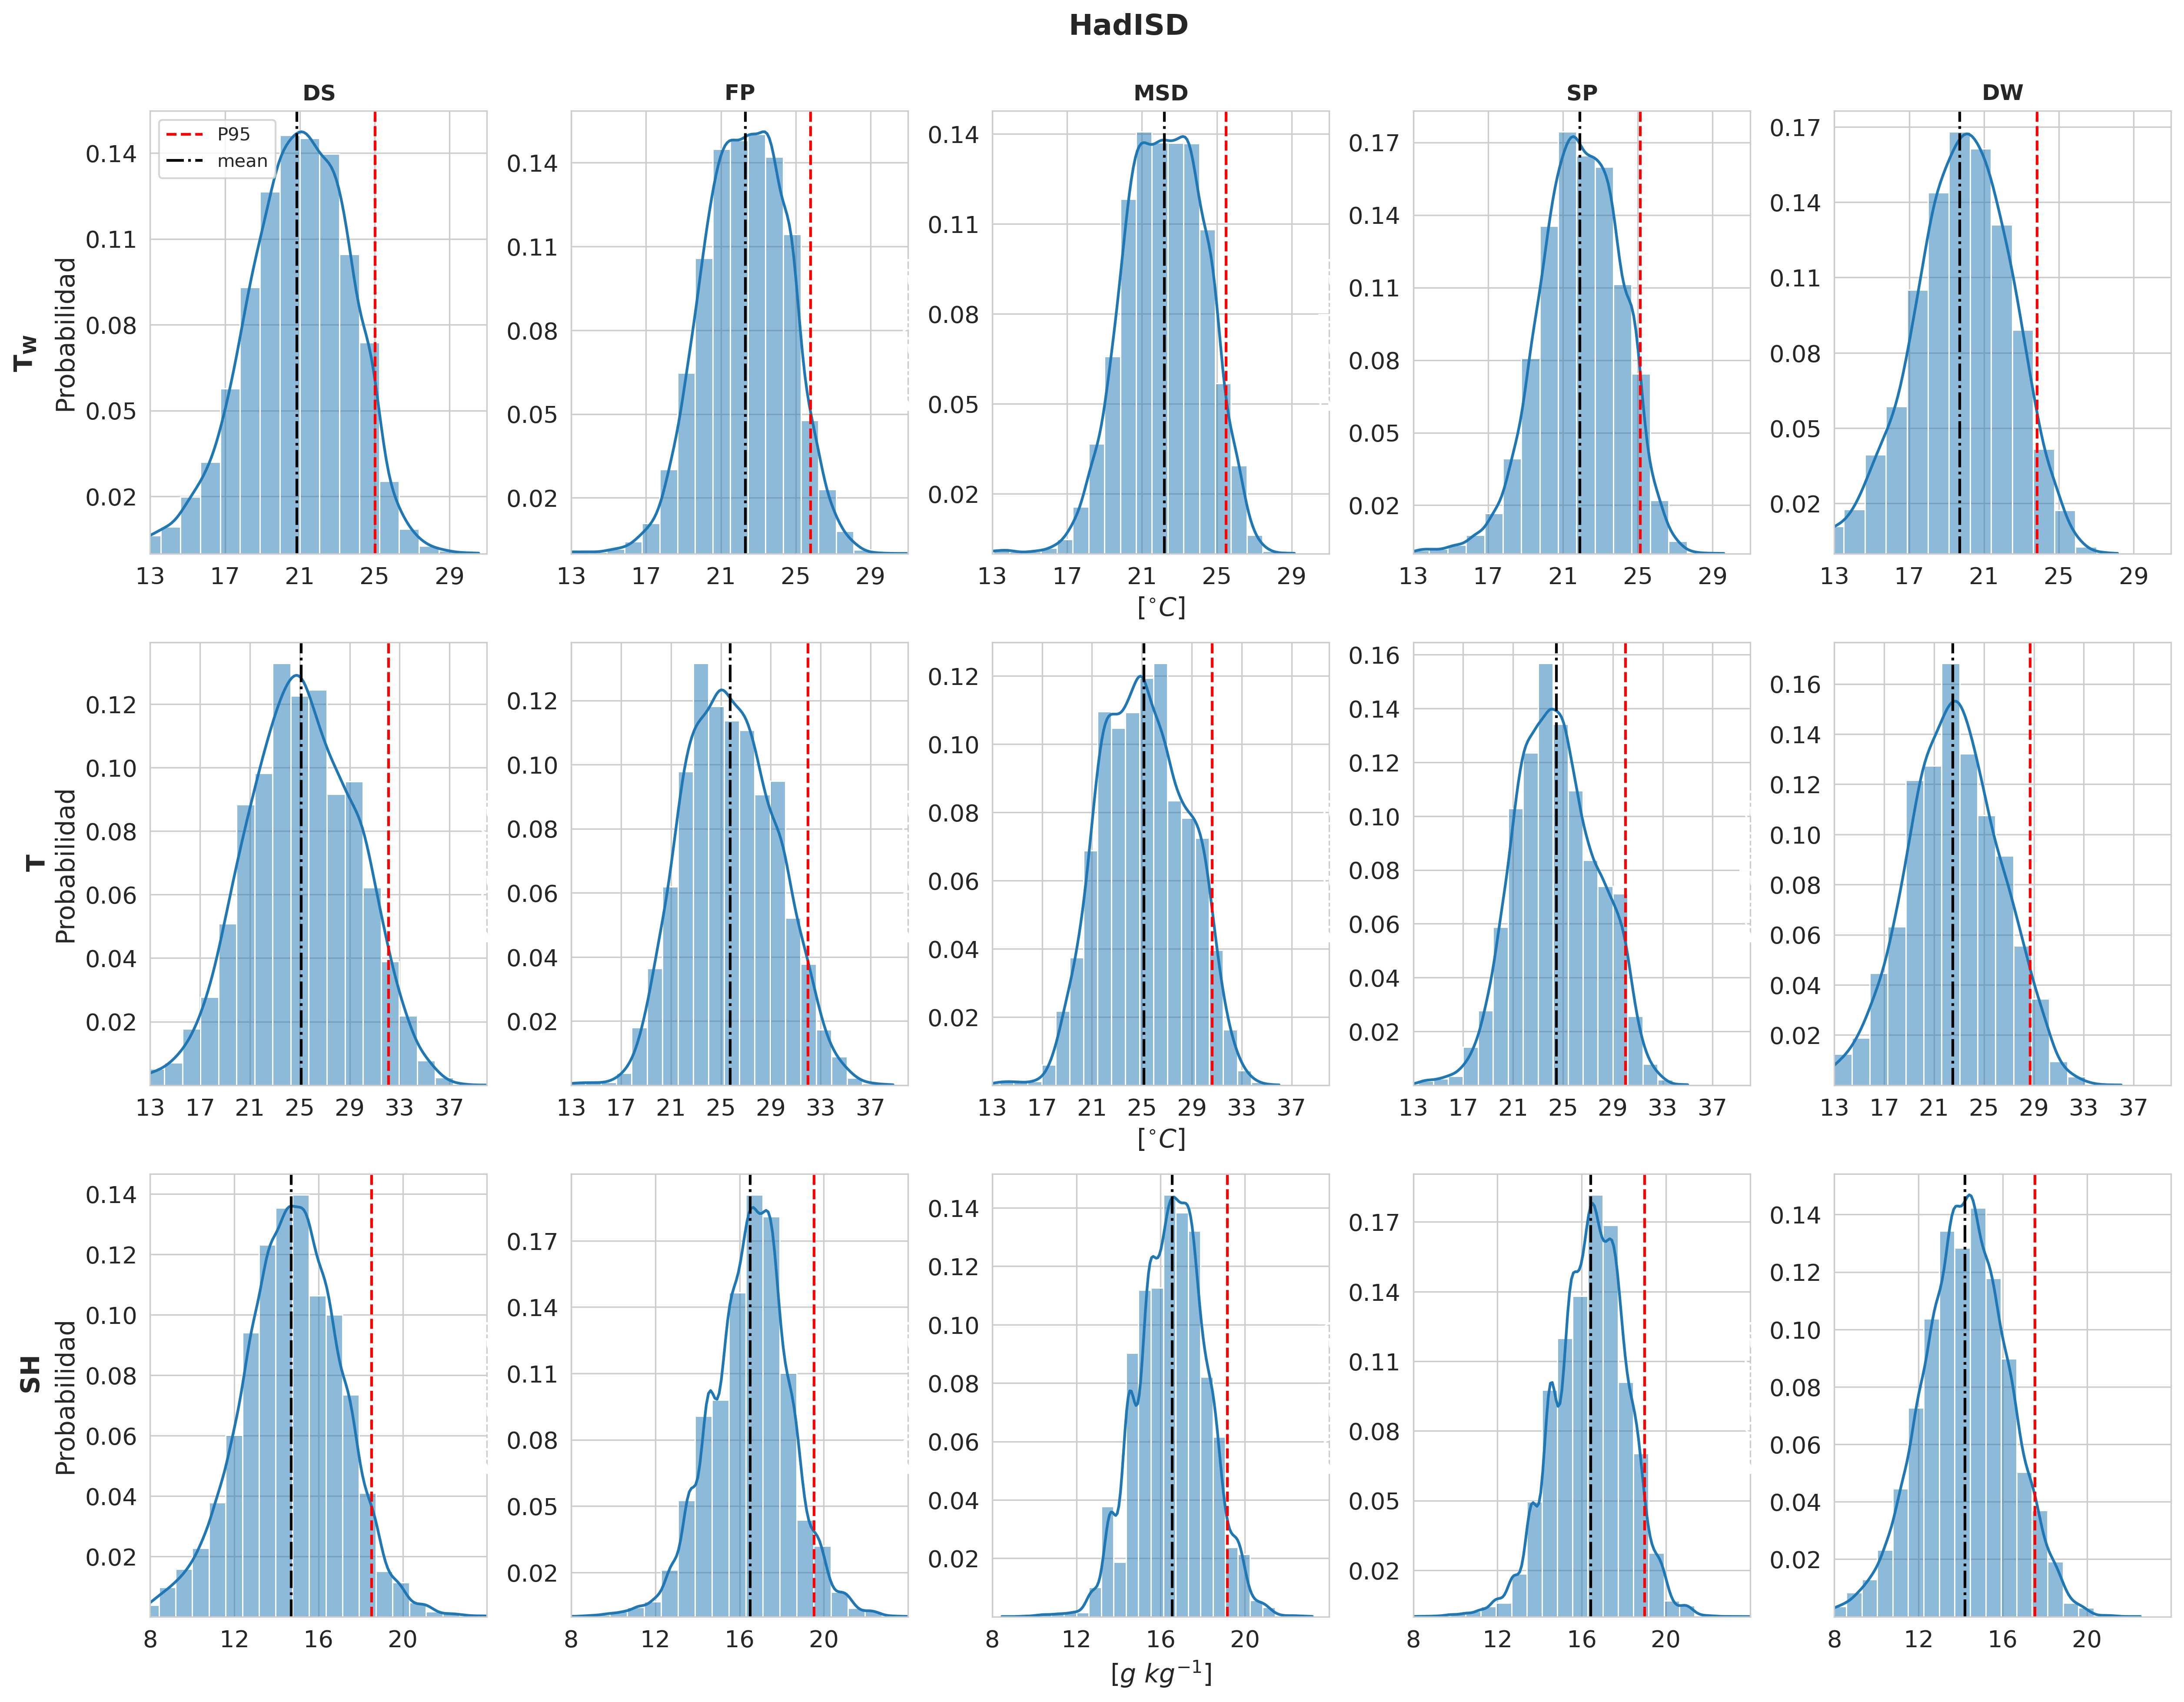

In [39]:
plt.figure(figsize=(20, 15),dpi=300)
sns.set_style("whitegrid")
plt.subplot(3,5,2)

ax=sns.histplot(data=Tw_fpeak_HAD-273.15,  kde=True,stat="probability" ,kde_kws={'bw_adjust':1.25},bins=25)  # Cambiar el estilo del gráfico

plt.xticks(np.arange(13,31,4),fontsize=13)
plt.xlim(13,31)
plt.yticks(np.arange(0.02, 0.15,0.03),fontsize=13)
plt.title(r"$\mathbf{FP}$",fontsize=12)
plt.axvline(HAD_e.P95.iloc[1], color='red', linestyle='--')
plt.axvline(HAD_e.Promedio.iloc[1], color='black', linestyle='-.',label="mean")

plt.ylabel("Probabilidad",fontsize=14,color="white")

plt.subplot(3,5,5)

sns.histplot(data=Tw_wdry_HAD-273.15, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(HAD_e.P95.iloc[4], color='red', linestyle='--')
plt.axvline(HAD_e.Promedio.iloc[4], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(13,31,4),fontsize=13)
plt.xlim(13,31)
plt.yticks(np.arange(0.02, 0.18,0.03),fontsize=13)
plt.title(r"$\mathbf{DW}$",fontsize=12)

plt.ylabel("Probabilidad",fontsize=14,color="white")

plt.subplot(3,5,3)

sns.histplot(data=Tw_MSD_HAD-273.15, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(HAD_e.P95.iloc[2], color='red', linestyle='--')
plt.axvline(HAD_e.Promedio.iloc[2], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(13,31,4),fontsize=13)
plt.xlim(13,31)
plt.yticks(np.arange(0.02, 0.16,0.03),fontsize=13)
plt.title(r"$\mathbf{MSD}$",fontsize=12)

plt.xlabel("$[^{\circ}C]$",fontsize=14)
plt.ylabel("Probabilidad",fontsize=14,color="white")


plt.subplot(3,5,4)
sns.histplot(data=Tw_speak_HAD-273.15, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(HAD_e.P95.iloc[3], color='red', linestyle='--')
plt.axvline(HAD_e.Promedio.iloc[3], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(13,31,4),fontsize=13)
plt.xlim(13,31)
plt.yticks(np.arange(0.02, 0.18,0.03),fontsize=13)
plt.title(r"$\mathbf{SP}$",fontsize=12)

plt.ylabel("Probabilidad",fontsize=14,color="white")


plt.subplot(3,5,1)
ax=sns.histplot(data=Tw_drys_HAD-273.15, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(HAD_e.P95.iloc[0], color='red', linestyle='--',label="P95")
plt.axvline(HAD_e.Promedio.iloc[0], color='black', linestyle='-.',label="mean")
plt.title(r"$\mathbf{DS}$",fontsize=12)
ax.text(7, 0.07, r'$\mathbf{T}$$\mathbf{_W}$',fontsize=14, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor')
plt.xticks(np.arange(13,31,4),fontsize=13)
plt.xlim(13,31)
plt.yticks(np.arange(0.02, 0.15,0.03),fontsize=13)
plt.legend(loc="upper left")

plt.ylabel("Probabilidad",fontsize=14)


plt.subplot(3,5,6)
ax=sns.histplot(data=T_drys_HAD,  kde=True,stat="probability" ,kde_kws={'bw_adjust':1.25},bins=25)
plt.axvline(HAD_e.P95.iloc[5], color='red', linestyle='--')
plt.axvline(HAD_e.Promedio.iloc[5], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(13,40,4),fontsize=13)
plt.xlim(13,40)
plt.yticks(np.arange(0.02, 0.13,0.02),fontsize=13)
ax.text(5, 0.07, r'$\mathbf{T}$',fontsize=14, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor')

plt.ylabel("Probabilidad",fontsize=14)

plt.subplot(3,5,7)
sns.histplot(data=T_fpeak_HAD, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(HAD_e.P95.iloc[6], color='red', linestyle='--')
plt.axvline(HAD_e.Promedio.iloc[6], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(13,40,4),fontsize=13)
plt.xlim(13,40)
plt.yticks(np.arange(0.02, 0.13,0.02),fontsize=13)
plt.ylabel("Probabilidad",fontsize=14,color="white")



plt.subplot(3,5,8)
sns.histplot(data=T_MSD_HAD, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(HAD_e.P95.iloc[7], color='red', linestyle='--')
plt.axvline(HAD_e.Promedio.iloc[7], color='black', linestyle='-.',label="mean")

plt.xticks(np.arange(13,40,4),fontsize=13)
plt.xlim(13,40)
plt.yticks(np.arange(0.02, 0.13,0.02),fontsize=13)

plt.ylabel("Probabilidad",fontsize=14,color="white")
plt.xlabel("$[^{\circ}C]$",fontsize=14)


plt.subplot(3,5,9)
sns.histplot(data=T_speak_HAD, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(HAD_e.P95.iloc[8], color='red', linestyle='--')
plt.axvline(HAD_e.Promedio.iloc[8], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(13,40,4),fontsize=13)
plt.xlim(13,40)
plt.yticks(np.arange(0.02, 0.16,0.02),fontsize=13)


plt.ylabel("Probabilidad",fontsize=14,color="white")
plt.subplot(3,5,10)
sns.histplot(data=T_wdry_HAD, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(HAD_e.P95.iloc[9], color='red', linestyle='--')
plt.axvline(HAD_e.Promedio.iloc[9], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(13,40,4),fontsize=13)
plt.xlim(13,40)
plt.yticks(np.arange(0.02, 0.17,0.02),fontsize=13)


plt.ylabel("Probabilidad",fontsize=14,color="white")

plt.subplot(3,5,11)
ax=sns.histplot(data=q_drys_HAD*1000,  kde=True,stat="probability" ,kde_kws={'bw_adjust':1.25},bins=25)
plt.axvline(HAD_e.P95.iloc[10], color='red', linestyle='--')
plt.axvline(HAD_e.Promedio.iloc[10], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(8,24,4),fontsize=13)
plt.xlim(8,24)
plt.yticks(np.arange(0.02, 0.15,0.02),fontsize=13)
ax.text(3, 0.08, r'$\mathbf{SH}$',fontsize=14, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor')



plt.ylabel("Probabilidad",fontsize=14)

plt.subplot(3,5,12)
sns.histplot(data=q_fpeak_HAD*1000, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(HAD_e.P95.iloc[11], color='red', linestyle='--')
plt.axvline(HAD_e.Promedio.iloc[11], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(8,24,4),fontsize=13)
plt.xlim(8,24)
plt.yticks(np.arange(0.02, 0.18,0.03),fontsize=13)



plt.ylabel("Probabilidad",fontsize=14,color="white")

plt.subplot(3,5,13)
sns.histplot(data=q_MSD_HAD*1000, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(HAD_e.P95.iloc[12], color='red', linestyle='--')

plt.axvline(HAD_e.Promedio.iloc[12], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(8,24,4),fontsize=13)
plt.xlim(8,24)
plt.yticks(np.arange(0.02, 0.15,0.02),fontsize=13)

plt.ylabel("Probabilidad",fontsize=14,color="white")
plt.xlabel("[$g$ $kg^{-1}$]",fontsize=14)


plt.subplot(3,5,14)
sns.histplot(data=q_speak_HAD*1000, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(HAD_e.P95.iloc[13], color='red', linestyle='--')
plt.axvline(HAD_e.Promedio.iloc[13], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(8,24,4),fontsize=13)
plt.xlim(8,24)
plt.yticks(np.arange(0.02, 0.17,0.03),fontsize=13)

plt.ylabel("Probabilidad",fontsize=14,color="white")


plt.subplot(3,5,15)
sns.histplot(data=q_wdry_HAD*1000, kde=True, stat="probability",bins=25, legend=False,kde_kws={'bw_adjust':1.25})
plt.axvline(HAD_e.P95.iloc[14], color='red', linestyle='--')
plt.axvline(HAD_e.Promedio.iloc[14], color='black', linestyle='-.',label="mean")
plt.xticks(np.arange(8,24,4),fontsize=13)
plt.xlim(8,24)
plt.yticks(np.arange(0.02, 0.15,0.02),fontsize=13)

plt.ylabel("Probabilidad",fontsize=14,color="white")


plt.suptitle(r"$\mathbf{HadISD}$", fontsize=16,y=0.93)
plt.subplots_adjust(wspace=0.25)
plt.savefig("MSD_HadISD.svg",bbox_inches="tight",dpi=300)
plt.savefig("MSD_HadISD.png",bbox_inches="tight",dpi=300)

plt.show()